In [1]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import csv
import glob
import os

In [2]:
# Reads monthly exchange rates from CHF to USD and writes the inverted rates (USD to CHF) to a new file.

input_file = '../data/monthly_exchange_rate/monthly_CHF_to_one_USD.csv'
output_file = '../data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSSZ']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXSZUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSSZ': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [3]:
# Reads monthly exchange rates from JPY to USD and writes the inverted rates (USD to JPY) to a new file.

input_file = '../data/monthly_exchange_rate/monthly_JPY_to_one_USD.csv'
output_file = '../data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSJP']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXJPUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSJP': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [4]:
import pandas as pd

# Chargement des fichiers CSV pour chaque devise
df_chf = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv')
df_jpy = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv')
df_aud = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_AUD.csv')
df_eur = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_EUR.csv')
df_gbp = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_GBP.csv')

# Renommer les colonnes de chaque DataFrame pour une meilleure identification
df_chf.rename(columns={'EXUSSZ': 'USD_per_CHF'}, inplace=True)
df_jpy.rename(columns={'EXUSJP': 'USD_per_JPY'}, inplace=True)
df_aud.rename(columns={'EXUSAL': 'USD_per_AUD'}, inplace=True)
df_eur.rename(columns={'EXUSEU': 'USD_per_EUR'}, inplace=True)
df_gbp.rename(columns={'EXUSUK': 'USD_per_GBP'}, inplace=True)

# Fusionner toutes les DataFrames sur la colonne 'date'
df_all = df_chf[['date', 'USD_per_CHF']].merge(df_jpy[['date', 'USD_per_JPY']], on='date', how='outer')\
    .merge(df_aud[['date', 'USD_per_AUD']], on='date', how='outer')\
    .merge(df_eur[['date', 'USD_per_EUR']], on='date', how='outer')\
    .merge(df_gbp[['date', 'USD_per_GBP']], on='date', how='outer')

# Save to csv
df_all.to_csv('../data/monthly_exchange_rate/merged_monthly_exchange_rates.csv', index=False)

# Afficher le DataFrame final
df_all.head()

,date,USD_per_CHF,USD_per_JPY,USD_per_AUD,USD_per_EUR,USD_per_GBP
0,2002-01-01,0.5985,0.0075,0.5170,0.8832,1.4322
1,2002-02-01,0.5893,0.0075,0.5128,0.8707,1.4227
2,2002-03-01,0.5973,0.0076,0.5256,0.8766,1.4230
3,2002-04-01,0.6045,0.0076,0.5352,0.8860,1.4429
4,2002-05-01,0.6294,0.0079,0.5498,0.9170,1.4598


In [ ]:
# Array with all the non-usd currencies
currencies = ["AUD", "EUR", "JPY", "CHF", "GBP"]
fx_df = pd.read_csv('../data/monthly_exchange_rate/merged_monthly_exchange_rates.csv', parse_dates=['date'])

for return_file in glob.glob("../data/monthly_returns/*.csv"):
    df = pd.read_csv(return_file, parse_dates=['date'])
    if 'currency' in df.columns:
        if df['currency'].iloc[0] in currencies:
            curr = df['currency'].iloc[0]
            fx_col = f'USD_per_{curr}'
        
            # To only keep month/year 
            df['month'] = df['date'].dt.to_period('M')
            fx_df['month'] = fx_df['date'].dt.to_period('M')
            df_merged = df[['month', 'currency', 'mportret', 'mportretx']].merge(fx_df[['month', fx_col]], on='month', how='inner')
            
            df_merged['mportret'] *= df_merged[fx_col]
            df_merged['mportretx'] *= df_merged[fx_col]
            
            # Save to new file
            df_merged.to_csv(return_file.replace("monthly_returns", f"converted_return"), index=False)

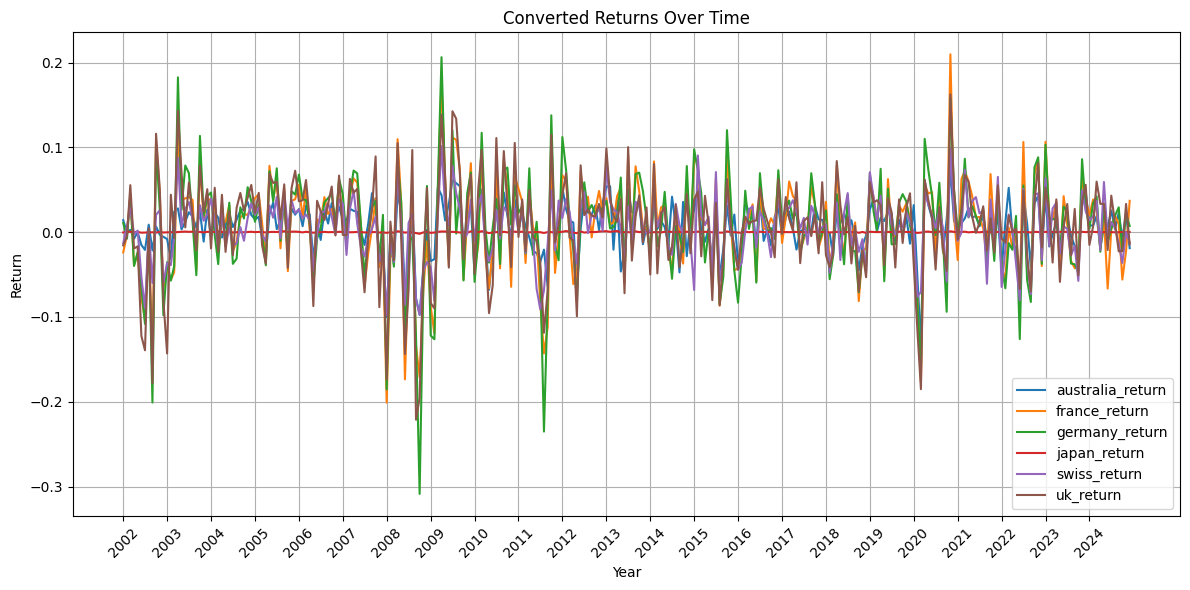

In [ ]:
# For the different countries (one plot for all the countries, see after what to do)
converted_files = glob.glob("../data/converted_return/*.csv")

plt.figure(figsize=(12, 6))
all_months=set()
for file in converted_files:
    df = pd.read_csv(file, parse_dates=['month'])
    
    
    # Aggregate mportret per month (optional if needed)
    df_grouped = df.groupby('month')['mportret'].mean().reset_index()
    plt.plot(df_grouped['month'], df_grouped['mportret'], label=os.path.basename(file).replace('.csv', ''))

    
    all_months.update(df_grouped['month'].unique())

# Select only 1 month per year for the x-axis ticks (e.g., January)
all_months = sorted(all_months)
selected_ticks = [m for m in all_months if m.month == 1]
# Shows only years
plt.xticks(selected_ticks, [m.strftime('%Y') for m in selected_ticks], rotation=45)
plt.title('Converted Returns Over Time')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

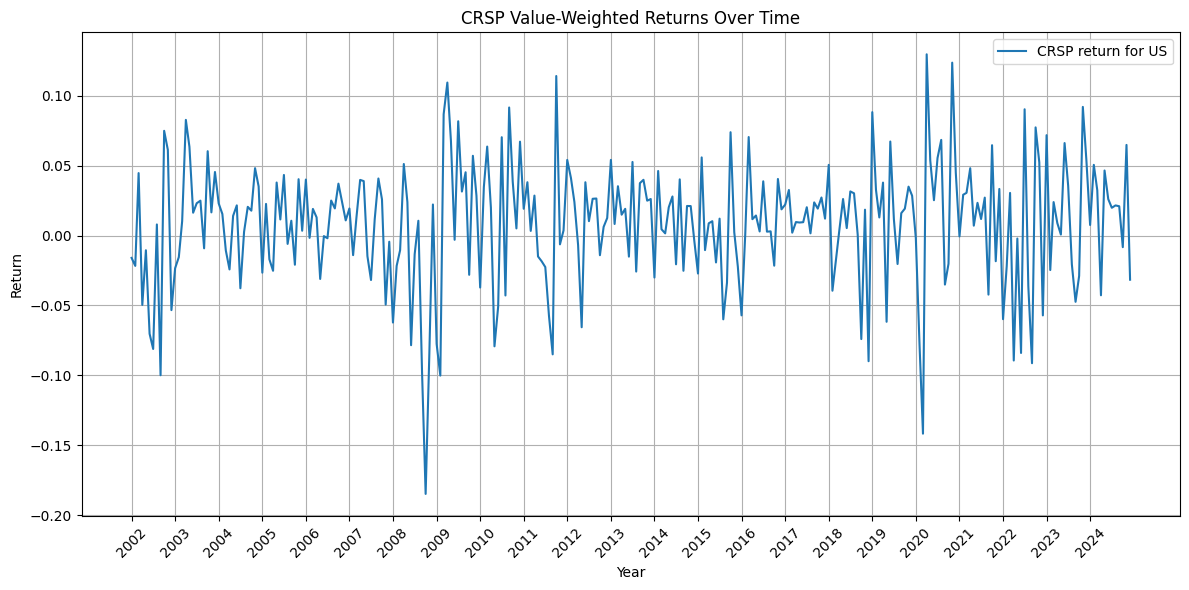

In [ ]:
#For US CSRP returns (basis to compare with the plot above)

df = pd.read_csv("../data/monthly_returns/csrp_return.csv", parse_dates=['date'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
df_grouped = df.groupby('month')['vwretd'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['month'], df_grouped['vwretd'], label='CRSP return for US')
all_months = df_grouped['month'].unique()
selected_ticks = [m for m in all_months if m.month == 1]
plt.xticks(selected_ticks, [m.strftime('%Y') for m in selected_ticks], rotation=45)

plt.title('CRSP Value-Weighted Returns Over Time')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()